<a href="https://colab.research.google.com/github/j-kohmaru-gunma/AraMaNet/blob/main/AraMaNet_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from matplotlib.animation import FuncAnimation

class AramaNet:

    def __init__(self, input_dim=2,max_depth=2,max_vnode=32):
        self.input_dim = input_dim
        self.vertex = VertexUnit(input_dim,max_nodes=max_vnode) #基点ユニット
        self.simplex = [] #単体ユニット（初期は0層）

    def forward(self, x, recon_error=0.1, max_depth=32):

        result = {}
        out_layer = -1

        # 基点ユニット推論
        result["out"] = self.vertex.forward(x)

        # Simplexユニット推論
        for i in range(min(max_depth,len(self.simplex))):
            result["out"] = self.simplex[i].forward(result["out"])
            out_layer += 1

        # 出力記録
        result["sparse_rate"] = self.get_sparse_rate(result["out"])
        result["idx"] = [np.argmax(result["out"])]
        result["vertex"] = self.get_vertex(out_layer,result["idx"])
        recon ,error = self.reconstruct_and_error(x, result["vertex"])
        result["recon"] = recon
        result["error"] = np.min(error)

        return result

    def train(self, X, input_dim=2, max_depth=2):

        #基点層の訓練
        self.vertex.train(X)

        #単体層の訓練
        layer_count = 0
        rec_rate = 0
        error = np.ones(len(X))
        rec_threshold = 0.05

        print("入力データ数:",len(X))
        print("再構成閾値:",rec_threshold)
        while True:
            out = []
            for i in range(len(X)):

                #すでに精度が出ているデータは飛ばす
                if error[i] < rec_threshold: continue

                #推論
                result = net.forward(X[i])

                #次層の訓練用に出力を保存
                out.append(result["out"])

                #再構成エラーを保存
                error[i] = result["error"]

            # 再構成精度が閾値を超えた割合を計算
            num = np.count_nonzero(error < rec_threshold)
            rec_rate = round(num/len(error),6)

            print(
                "layer:",layer_count,
                " recon_rate:",rec_rate*100,"%(",num,"/",len(error),")",
            )

            #終了判定
            layer_count += 1
            if layer_count >= self.input_dim+1 or rec_rate > 98:
                break;

            # 単体層を追加して、再訓練
            self.simplex.append(SimplexUnit(k=layer_count+1))
            self.simplex[layer_count-1].optimize(out)

    def get_vertex(self,layer_num=0,node_idx=[0]):

        for i in range(layer_num+1):
            if len(self.simplex[layer_num-i].connect) > 0:
                node_idx = self.simplex[layer_num-i].connect[node_idx]
            else:
                node_idx = np.argsort(-self.simplex[layer_num-i].weights[node_idx])[:self.simplex[i].k]

        return np.unique(node_idx)

    def get_sparse_rate(self,y):

        sorted_y = np.sort(y)[::-1]
        sr = 1

        #一位が二位の活性値の何倍か
        sr = (sorted_y[0] - sorted_y[1]) / (sorted_y[0] + 1e-8)

        #一位と二位の活性値の差
        #sr = sorted_y[0] - sorted_y[1]

        #一位が活性値平均の何倍か
        #sr = sorted_y[0] / np.sum(sorted_y) * len(sorted_y)

        return sr

    def reconstruct_and_error(self, x, idx_list):
        # 各出力ノードに対応する基点群からバリセントリック近似
        points = self.vertex.centers[idx_list]  # 基点
        inv_d = self.vertex.out[idx_list]  # 逆距離
        weights = (inv_d / np.sum(inv_d))  # 正規化（バリセントリック風）
        recon = np.sum(points * weights[:, np.newaxis], axis=0)
        return recon, np.linalg.norm(x - recon, axis=0)


class VertexUnit:

    def __init__(self, input_dim=2, max_nodes=32, sparse_rate=0.2):
        self.input_dim = input_dim
        self.centers = np.zeros((max_nodes, input_dim)) #基点ノードの位置
        self.max_nodes = max_nodes #最大ノード数
        self.sparse_rate = sparse_rate #出力スパース化の割合
        self.out = np.zeros(len(self.centers)) #出力保存用１
        self.scores = np.zeros(len(self.centers))
        self.centers_log = []
        self.scores_log = []

    def forward(self, x):
        # 入力xに対し、基点ノードとの距離を計算し、逆距離で出力を算出
        dists = np.linalg.norm(x - self.centers, axis=1)
        self.out = 1 / (dists + 1e-8)  # ゼロ除算防止の微小値加算

        #出力のスパース化
        self.out = self.sparse(self.out)

        return self.out

    def train(self, X, epochs=200):

        #データをランダムに選択し、ノードを初期配置
        idx = np.random.choice(len(X), size=self.max_nodes, replace=False)
        self.centers = X[idx]

        self.centers_log.append(self.centers.copy())
        self.scores_log.append(self.scores.copy())

        #エポック数分繰り返し
        for i in range(epochs):

            #ノードの移動
            for x in X:
              self.update(x)

            self.centers_log.append(self.centers.copy())
            self.scores_log.append(self.scores.copy())

            #ノードの再配置
            if i % 3 == 0:
              self.redistribute_nodes()

    def update(self, x):
        """
        入力データxに対し学習を実行。
        Winnerノードを決定し、移動度合いを調整して移動。
        その後スコアを更新し、仮置きノードの管理も行う。
        """

        # 出力を計算
        y = self.forward(x)

        # Winnerノードを決定
        sort_idx = np.argsort(y)[::-1]
        winner_idx = sort_idx[0]
        winner_y = y[winner_idx]

        # スコア際立ち度計算用
        normalized_y = y / np.sum(y)

        # Winnerノードの際立ち度（反応強さが２位よりどれだけ高いか）
        winner_uniqueness = (y[sort_idx[0]] - y[sort_idx[1]]) / (y[sort_idx[0]] + 1e-6)

        # ノードの移動度を際立ち度に基づき調整（際立ち度が低ければ移動量を減らす）
        move_amount = winner_uniqueness

        # 本ノードの移動
        # Winnerノードの周辺に他ノードが密集しているほど移動量は小さくなる
        # 逆に孤立しているなら移動量は大きくなる（際立ち度が反映済み）
        #self.centers[winner_idx] += move_amount * (x - self.centers[winner_idx])


        # 本ノードの移動
        # Winnerノードはデータに近づけるように更新
        # 二位は際立ち度に基づいてWinnerから遠ざけるように更新
        #self.centers[sort_idx[1]] += (self.centers[sort_idx[1]] - self.centers[winner_idx])
        self.centers[winner_idx] += 0.1 * (x - self.centers[winner_idx])


        # スコア更新（単純加算＋スコアを0~1にクリップ）
        self.scores[winner_idx] += 1
        #self.scores[winner_idx] = np.clip(self.scores[winner_idx], 0, 1)

        """
        # 外れ値判定
        uniqueness_ratio = (winner_y - np.mean(y)) / (np.std(y) + 1e-6)
        is_outlier = uniqueness_ratio < 1  # 例: threshold = 1.0

        if winner_idx < self.max_nodes:
            # 本ノードの移動
            # Winnerノードの周辺に他ノードが密集しているほど移動量は小さくなる
            # 逆に孤立しているなら移動量は大きくなる（際立ち度が反映済み）
            self.centers[winner_idx] += move_amount * (x - self.centers[winner_idx])

            # スコア更新（単純加算＋スコアを0~1にクリップ）
            self.scores[winner_idx] += winner_uniqueness
            self.scores[winner_idx] = np.clip(self.scores[winner_idx], 0, 1)

            # 外れ値であれば仮置きノード候補として追加検討
            if is_outlier:
                self._handle_provisional_node(x, winner_uniqueness)

        else:
            # 仮置きノードの移動（仮置きノードは移動率を固定小さめに）
            prov_idx = winner_idx - self.n_nodes
            self.provisional_centers[prov_idx] += self.lr * 0.5 * (x - self.provisional_centers[prov_idx])

            # スコア更新（仮置きノードのスコア）
            self.provisional_scores[prov_idx] += winner_uniqueness
            self.provisional_scores[prov_idx] = np.clip(self.provisional_scores[prov_idx], 0, 1)

            # 仮置きノードのスコアが本ノードの最低スコアを超えたら入れ替え
            min_score_idx = np.argmin(self.scores)
            if self.provisional_scores[prov_idx] > self.scores[min_score_idx]:
                # 本ノードの最低スコアノードと入れ替え
                self.centers[min_score_idx] = self.provisional_centers[prov_idx].copy()
                self.scores[min_score_idx] = self.provisional_scores[prov_idx]
                # 仮置きノードを削除
                self.provisional_centers = np.delete(self.provisional_centers, prov_idx, axis=0)
                self.provisional_scores = np.delete(self.provisional_scores, prov_idx)
                self.n_nodes = len(self.centers)
        """

    def _handle_provisional_node(self, x, uniqueness_score):
        """
        外れ値検出時に仮置きノードを管理する内部関数
        仮置きノードが最大数を超えたら最もスコアの低い仮置きノードと入れ替える。
        """
        if len(self.provisional_centers) < self.max_provisional_nodes:
            # 仮置きノードを追加
            self.provisional_centers = np.vstack([self.provisional_centers, x.reshape(1, -1)])
            self.provisional_scores = np.append(self.provisional_scores, 0)
        else:
            # 仮置きノードの中で最低スコアのものを探す
            min_idx = np.argmin(self.provisional_scores)
            if uniqueness_score > self.provisional_scores[min_idx]:
                # スコアが低い仮置きノードと入れ替え
                self.provisional_centers[min_idx] = x
                self.provisional_scores[min_idx] = 0

    def redistribute_nodes(self, perturb_std=0.05):
        """
        スコアの低いノードをスコアの高いノード近傍に再配置して
        ノードの密集を緩和する処理
        仮置きノードは再配置の対象外
        """
        if self.max_nodes < 2:
            return

        # スコアで昇順ソート
        sorted_indices = np.argsort(self.scores)
        # 最もスコアの低いノード1個を選択して削除候補に
        prune_idx = sorted_indices[0]
        # 複製先は上位スコアのノードの中からランダムに1個選ぶ
        top_indices = sorted_indices[-max(1, self.max_nodes//3):]
        dup_idx = np.random.choice(top_indices)

        # 低スコアノードを高スコアノードの近くに移動（少しだけランダムずらし）
        perturb = np.random.randn(self.input_dim) * perturb_std
        self.centers[prune_idx] = self.centers[dup_idx] + perturb

        # スコアは複製元ノードの半分にリセット
        self.scores[[prune_idx,dup_idx]] = self.scores[dup_idx] * 0.5

    # スパース化
    def sparse(self, x):
      return x

class SimplexUnit:
    def __init__(self, input_dim=2, max_nodes=32, k=2, sparse_rate=0.6):
        self.max_nodes = max_nodes #最大ノード数
        self.k = k # 各ノードが接続を持つ基点の数
        self.connect = np.zeros((0,k),dtype=np.int32) # 各ノードが接続する基点の組み合わせ
        self.connect_weight = np.zeros(0) # 接続強度
        self.out = np.array([]) #単体層の出力保存用1
        self.out_idx = np.array([]) #単体層の出力保存用2
        self.weights = np.abs(np.random.rand(max_nodes, input_dim))


    def forward(self, x):

        #接続が訓練済みかどうかで処理を分ける
        if len(self.connect) > 0: # 訓練済
            topk_indices = self.connect

        else: # 訓練中
            # 各ノードごとに、重みの大きい上位k個のインデックスを取得
            topk_indices = np.argpartition(-self.weights, kth=self.k-1, axis=0)[:, :self.k]

        # 入力xのうち、選ばれたインデックスに対応する値を取り出す（各ノードごとに）
        topk_values = np.take_along_axis(x[None, :], topk_indices, axis=1)

        # 有効な要素数を数え、平均値を求める（= 活性値）
        valid_counts = np.full((len(topk_indices)), self.k)
        sums = np.sum(topk_values, axis=1)
        self.out = sums / valid_counts  # 単純平均

        return self.out


    # 全テストデータ用いた簡易最適化
    def optimize(self, X, max_nodes=31):
        top_k = np.argsort(X)[:,-self.k:]
        top_k = np.sort(top_k,axis=1)

        unique_rows, counts = np.unique(top_k, axis=0, return_counts=True)
        idx = np.argsort(-counts)
        unique_rows = unique_rows[idx][0:max_nodes]
        counts = counts[idx][0:max_nodes]
        for row, count in zip(unique_rows, counts):
            self.connect = np.insert(self.connect, 0, row, axis=0)
            self.connect_weight = np.insert(self.connect_weight, 0, count, axis=0)

        # 結果表示
        return unique_rows, counts

# データ準備
X, _ = make_swiss_roll(n_samples=1000, noise=0.2)
X = X[:, [0, 2]]  # 2次元に射影
X = (X / np.max(np.abs(X)))

# ネットワーク初期化
net = AramaNet(input_dim=len(X[0]),max_vnode=32)

#訓練に
net.train(X)

入力データ数: 1000
再構成閾値: 0.05
layer: 0  recon_rate: 57.199999999999996 %( 572 / 1000 )
layer: 1  recon_rate: 97.5 %( 975 / 1000 )
layer: 2  recon_rate: 97.5 %( 975 / 1000 )


In [ ]:
#!apt-get -y install ffmpeg

#基点層訓練アニメ
centers = net.vertex.centers_log  # shape = (frame数, ノード数, 2)
scores = net.vertex.scores_log  # shape = (frame数, ノード数, 2)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
scat_data = ax.scatter(X[:, 0], X[:, 1], s=2, c='gray', alpha=0.2, label='data')
scat_nodes = ax.scatter([], [], s=20, c=[], cmap='rainbow', label='nodes')
def init():
    scat_nodes.set_offsets(np.empty((0, 2)))
    return scat_nodes,
def update(frame):
    scat_nodes.set_offsets(centers[frame])
    score = scores[frame]/np.mean(scores[frame])  # shape=(ノード数,)
    scat_nodes.set_array(score)  # カラーマッピング用
    return scat_nodes,
anim = FuncAnimation(fig, update, frames=len(centers)-1, init_func=init, interval=50, blit=True)

# MP4で保存
anim.save("training_animation.mp4", writer="ffmpeg", fps=5)

# Colabでダウンロードリンクを表示
from google.colab import files
files.download("training_animation.mp4")
plt.close()


/tmp/ipython-input-107-2501486870.py:18: RuntimeWarning: invalid value encountered in divide
  score = scores[frame]/np.mean(scores[frame])  # shape=(ノード数,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

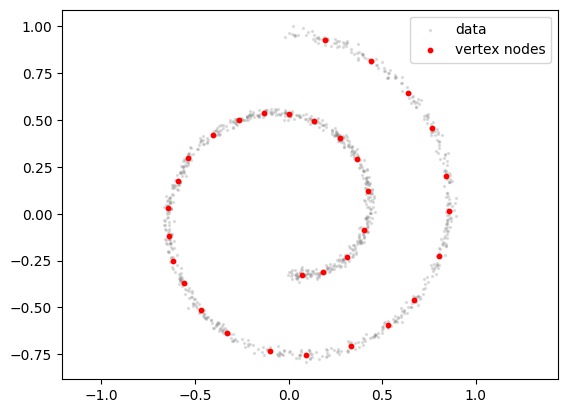

In [ ]:
#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#頂点層
plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='red', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

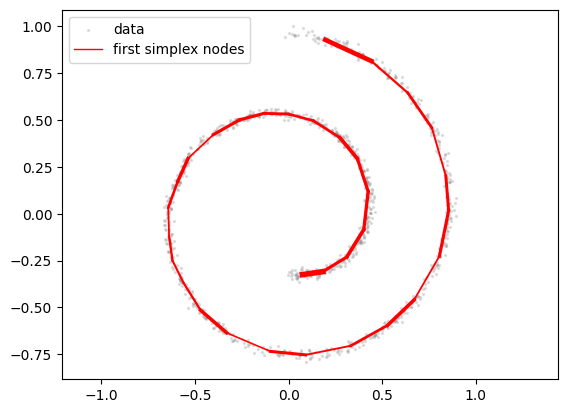

In [ ]:
#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#第一単体層
line_idx = net.simplex[0].connect
w = net.simplex[0].connect_weight
w = w/np.max(w)
for i in range(len(line_idx)):
    p1 = net.vertex.centers[line_idx[i,0]]
    p2 = net.vertex.centers[line_idx[i,1]]
    plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', lw=w[i]*4)

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', label='first simplex nodes', lw=1)

plt.legend()
plt.axis("equal")
plt.show()

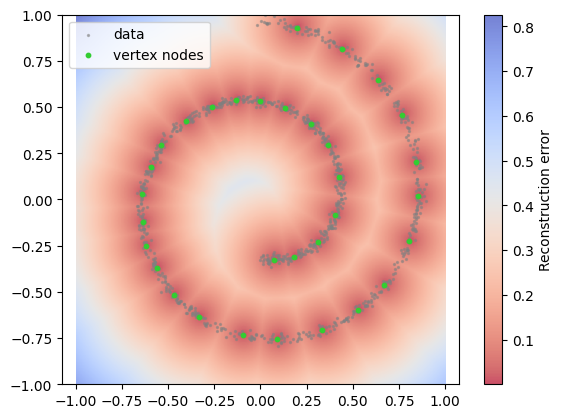

In [ ]:
#推論精度可視化
Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = (net.forward([x,y],max_depth=0))["error"]

#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#再構成誤差ヒートマップ
heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

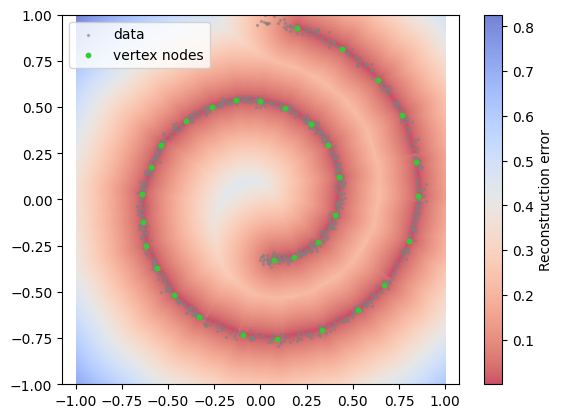

In [ ]:
#推論精度可視化
Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = min((net.forward([x,y],max_depth=0))["error"],(net.forward([x,y],max_depth=1))["error"])

#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#再構成誤差ヒートマップ
heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

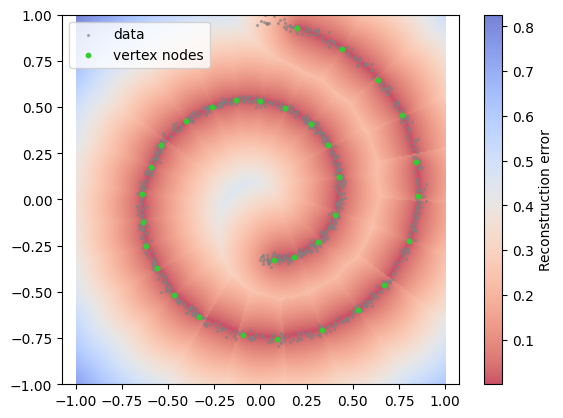

In [ ]:
#推論精度可視化
Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = (net.forward([x,y],max_depth=1))["error"]

#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#再構成誤差ヒートマップ
heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

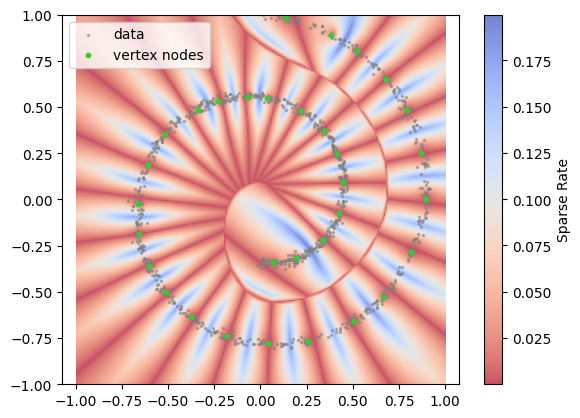

In [ ]:
#スパース性可視化
Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = (net.forward([x,y]))["sparse_rate"]

#可視化
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

#再構成誤差ヒートマップ
heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Sparse Rate')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()